In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from collections import defaultdict
%matplotlib inline

## Create a database of random actions and associated rewards
---
#### Configuration of the problem

The envirenment is a cartpole and the goal is to maintain the bar in vertical position.
The agent can take two actions (0, 1):
(we apply a force constraint: acceleration (not sure about this point))
- O: move left 
- 1: move right

The environment makes a step, returns the "state", "reward", "done", and "info".
The state is a numpy array containing 4 measurements: [pos, velocity, angle, angular_vel]

---
#### How to compute the action in Random Search algorithm

- compute the initial state $S_t$
- define a random vector $\theta$ with the same shape as the state vector
- compute the action: $a_{t+1} = max(0, \sum (S_t)_i.\theta_i)$
- run a loop
---

#### Results

After running the experiment, some random parameters managed to solve the problem, however the frequence of success is low. In order to improve the performance of the model, we will save the parameters and associated rewards. Using this database, we try to find out if there is correlation between the parameters and the reward.

In [5]:
# Load saved parameters and associated rewards
best_parameters = np.load("best_parameters.npy")
rewards = np.load("rewards.npy")
X_dataset = pd.DataFrame(best_parameters, columns=["X1", "X2", "X3","X4"])
y = rewards
X_dataset["Y"] = y

In [6]:
X_dataset.head()

,X1,X2,X3,X4,Y
0,-0.229417,-0.185708,0.366643,-0.335309,10.0
1,-0.503280,-0.887853,0.561946,-0.671570,10.0
2,0.594694,0.257690,-0.547591,0.512666,47.0
3,0.771037,0.500262,0.091891,0.127957,10.0
4,-0.649169,0.115899,0.321373,0.420118,152.0


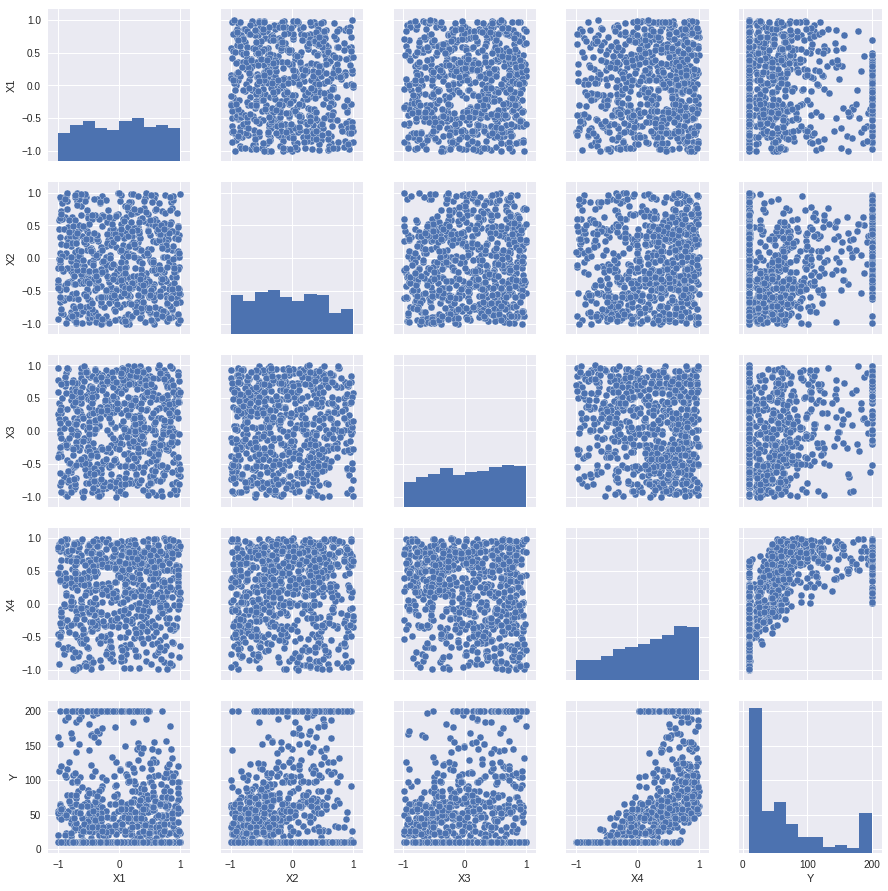

In [7]:
sns.pairplot(X_dataset)

As we see in the figure below, as expected, there is no correlation between the parameters.
"X4" seems to be the have the most signification correlation with the reward.
An experiment we can do is to create three categories of parameters using the value of the reward as "critère" of evaluation:
- bad parameters: reward < 100
- average parameters: 100 < reward < 150
- good parameters: reward = 200

In [12]:
X_dataset["average_score"] = X_dataset.apply(lambda row:1 if (row["Y"]<150 and row["Y"]>100) else 0, axis=1)
X_dataset["good_score"] = X_dataset.apply(lambda row: 1 if row["Y"]>150 else 0, axis=1)
good_data = X_dataset[X_dataset.Y==200].drop(["average_score", "good_score"], axis=1)
aver_data = X_dataset[X_dataset.average_score==1].drop(["average_score", "good_score"], axis=1)

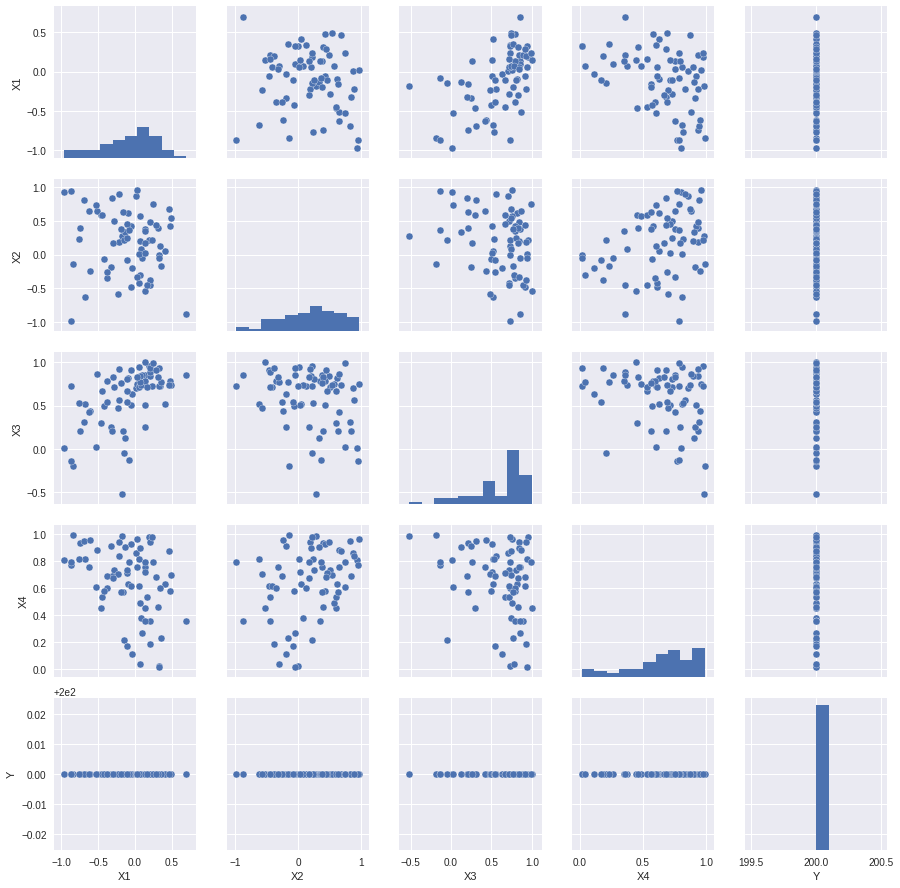

In [16]:
prplot = sns.pairplot(good_data)

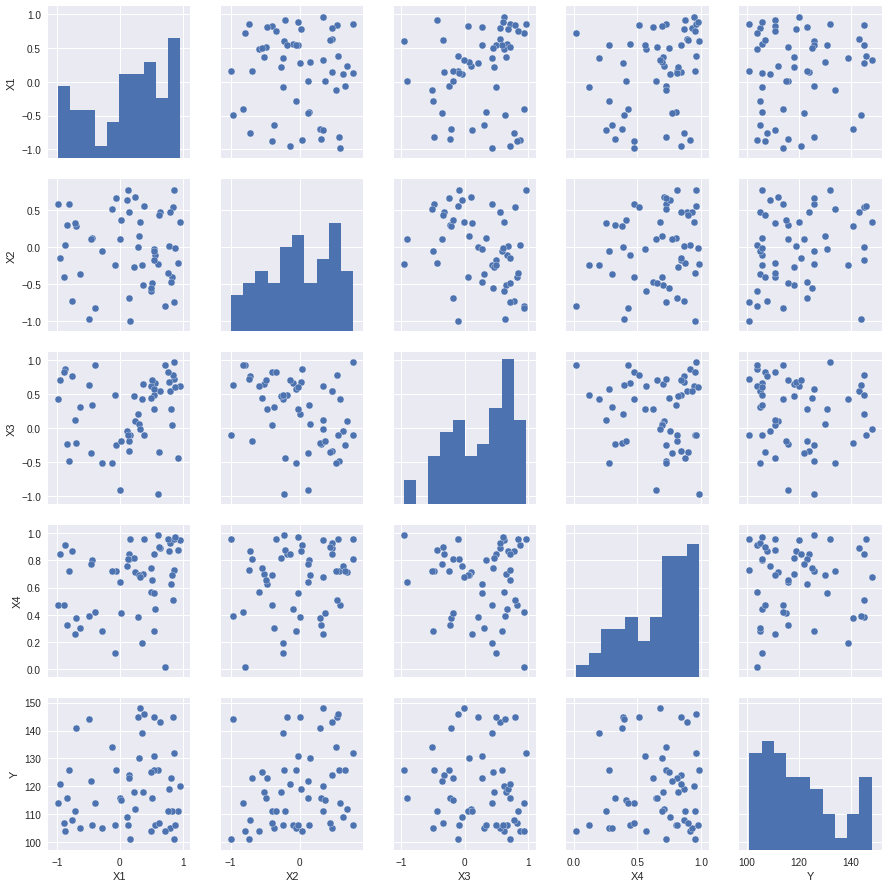

In [17]:
sns.pairplot(aver_data)

Comparing to the first plot, these two plots are more significant. We will only focus on good parameters as our goal is to improve the performance of the model.
We will use linear regression classifier to find out whether there exist correlation between parameters

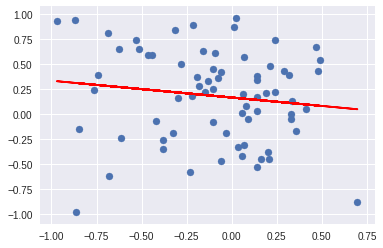

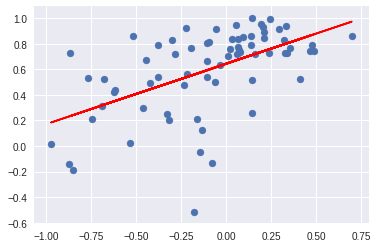

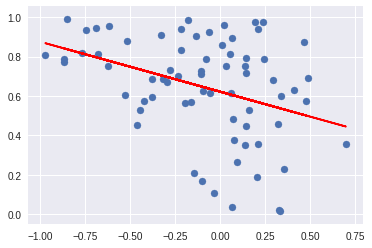

In [27]:
clf = LinearRegression()
coefficients = {}
intercepts = {}

for i in range(1,4):
    x = good_data["X1"].values.reshape(-1, 1)
    y = good_data["X"+ str(i+1)].values.reshape(-1, 1)
    clf.fit(x,y)
    prediction = clf.predict(x)
    plt.figure()
    plt.scatter(x="X1", y="X"+str(i+1), data=good_data)
    plt.plot(x, prediction, c='r')
    coefficients["X"+str(i+1)] = clf.coef_
    intercepts["X"+str(i+1)] = clf.intercept_

In [28]:
print("Coefficients: ", coefficients, "\nIntercepts: ", intercepts)

Coefficients:  {'X4': array([[-0.25372267]]), 'X2': array([[-0.16849618]]), 'X3': array([[ 0.47281522]])} 
Intercepts:  {'X4': array([ 0.62152265]), 'X2': array([ 0.16654202]), 'X3': array([ 0.64276936])}


Note: We can split our data into N sub_datasets and run linear regression on each one. after that we can measure the mean and the standard error of the predicted parameters in order to measure the t-statistic to make sure that the correlation between predictors is not dut to chance.

In [56]:
coef=[]
clf = LinearRegression()
for i in range(20):
    x = best_parameters[i*20: (i+1)*20]
    y = rewards[i*20: (i+1)*20]
    clf.fit(x, y)
    coef.append(clf.coef_)
    

In [57]:
coef

[array([-20.50844508,  -2.22557985,  46.60941966,  86.70733247]),
 array([ -5.49135473,  41.16617042,  26.61165058,  77.84277933]),
 array([ -3.12215042e+01,   8.87647821e-02,   2.66212515e+01,
          1.37856248e+02]),
 array([-34.22083538, -27.54924418,  33.52837835,  86.2445412 ]),
 array([ -7.91410433,  21.77672208,  26.51607335,  76.54270197]),
 array([ -4.72917171,  22.62869153,  -6.59114557,  89.73192615]),
 array([-30.31876285,  26.47990893,  74.60101567,  90.28885754]),
 array([-11.46767277, -16.76562973,  32.15064352,  71.48019243]),
 array([ 19.8705681 ,  10.12741956,  65.9301869 ,  75.05427542]),
 array([-24.70513303,   5.00911988,  32.16991853,  83.5428898 ]),
 array([-33.69559551,   3.56524552,   0.48558311,  70.7857493 ]),
 array([-18.90283589,   9.9708997 ,  37.88239097,  85.36397315]),
 array([ -7.58661381,   2.64266119,  64.8855476 ,  89.94543942]),
 array([-19.33404779, -14.3874986 ,  49.48234134,  80.91664918]),
 array([-14.1206061 , -26.92091254,  58.88987754,  6

In [60]:
mean = np.mean(coef, axis=0)

In [61]:
std = np.std(coef, axis=0)

In [62]:
t = mean/std

In [64]:
abs(t)

array([ 1.19981567,  0.1927584 ,  1.64318633,  4.68866102])

Know we will use these coefficients and intercepts to define a new random research model as following:
- we choose X1 randomly in [-0.5, 0.5]
- we define the rest of parameters based on the value of X1:
    - X2 = -0.16 * X1 + 0.166
    - X3 =  0.47 * X1 + 0.64
    - X4 = -0.25 * X1 + 0.62
- we repeat the some algorithm and save the data to test the performance of the model
We repeat the some plots as before.

In [3]:
X_rand = np.load("best_parameters_rand.npy")
Y_rand = np.load("rewards_rand.npy")
X_rand_dataset = pd.DataFrame(X_rand, columns=["X1", "X2", "X3", "X4"])
X_rand_dataset["Y"] = Y_rand

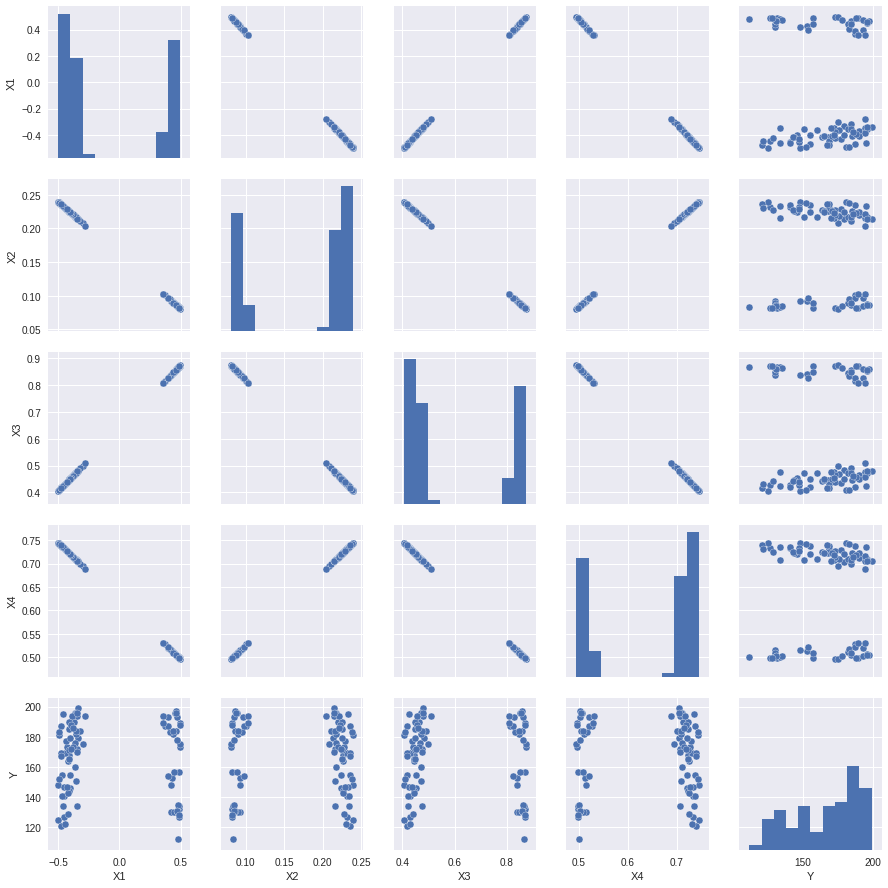

In [5]:
sns.pairplot(X_rand_dataset[X_rand_dataset.Y<200])

We can easily notice that the performance of the model decrease in the two extreems of X1 values.
We imposed X1 to be in [-0.5, 0.5]. Let's try to impose X1 to be in [-0.25, 0.25]
Here is the result:

In [8]:
X_rand2 = np.load("best_parameters_rand2.npy")
Y_rand2 = np.load("rewards_rand2.npy")
X_rand2_dataset = pd.DataFrame(X_rand2, columns=["X1", "X2", "X3", "X4"])
X_rand2_dataset["Y"] = Y_rand2

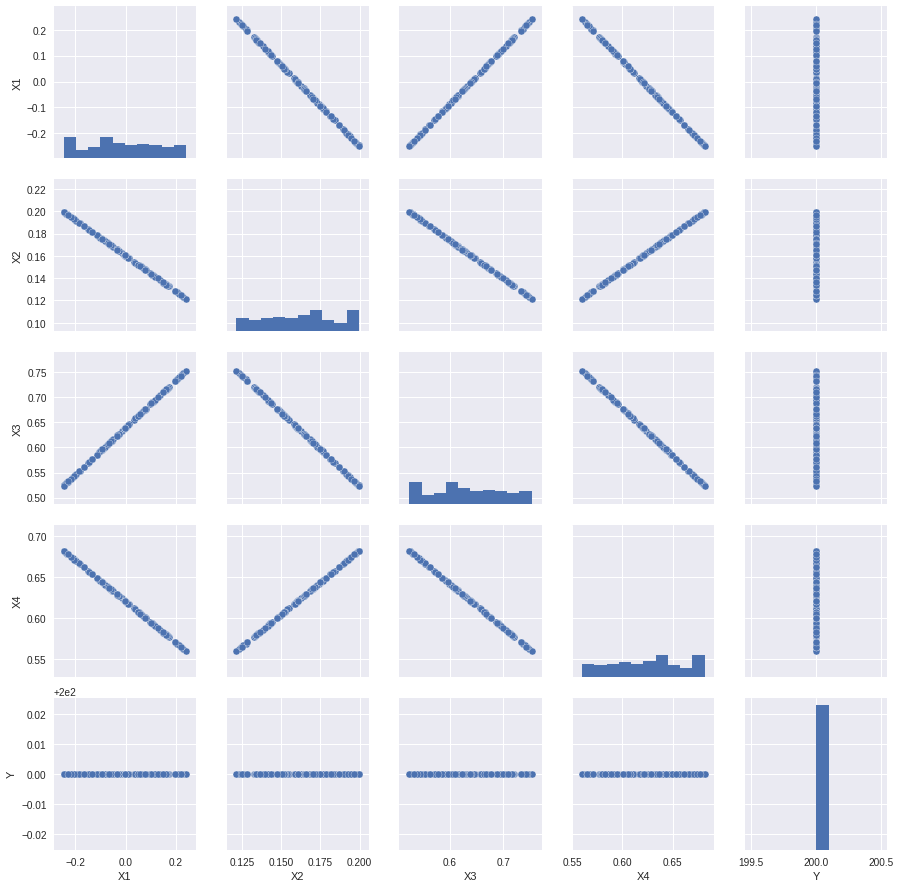

In [9]:
sns.pairplot(X_rand2_dataset)

Oppa!! Now we can see that our model is stable with good performance. 
:)